In [55]:
import sklearn

In [1]:
from sklearn.datasets import make_circles

# make 1000 samples
n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [2]:
len(X), len(y)

(1000, 1000)

In [3]:
print(f"First 5 samples of x\n: {X[:5]}")
print(f"First 5 samples of y: {y[:5]}")

First 5 samples of x
: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: [1 1 1 1 0]


In [4]:
import pandas as pd

circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})

circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


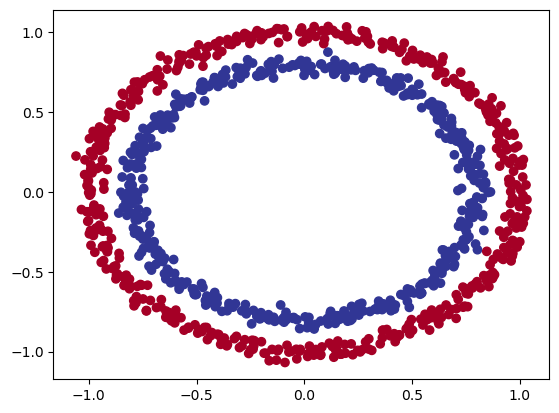

In [5]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [6]:
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

#### Convert data into tensors

In [8]:
import torch
torch.__version__

'2.5.1+cu121'

In [9]:
type(X)

numpy.ndarray

In [10]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [11]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [12]:
# split data into training into test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [13]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [14]:
# 2. Building a model
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [15]:
class CircleModelV0(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        # create input layers
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscales to 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from previous layer and outputs a sigle feature (same shape as y)

        # USING nn.Sequential for building a neural network
        # self.two_linear_layers = nn.Sequential(
        #     nn.Linear(in_features=2, out_features=5),
        #     nn.Linear(in_features=5, out_features=1)
        # )

    # 3. define a foward() method
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer_2(self.layer_1(x))
        # return self.two_linear_layers(x)
    
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [17]:
# model_0 = nn.Sequential(
#     nn.Linear(in_features=2, out_features=5),
#     nn.Linear(in_features=5, out_features=1)
# ).to(device)

# model_0

In [18]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.5449, -0.3530],
                      [ 0.6640, -0.1617],
                      [-0.0155, -0.3130],
                      [ 0.4589, -0.0122],
                      [-0.1583, -0.5113]], device='cuda:0')),
             ('layer_1.bias',
              tensor([ 0.3546, -0.2090, -0.2517, -0.5748,  0.5850], device='cuda:0')),
             ('layer_2.weight',
              tensor([[-0.3140,  0.2298,  0.2934, -0.2899,  0.1367]], device='cuda:0')),
             ('layer_2.bias', tensor([0.4455], device='cuda:0'))])

In [19]:
# Make  predictions
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions : {len(untrained_preds)}, Shape : {untrained_preds.shape}")
print(f"Length of test samples : {len(X_test)}, Shape : {X_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 labels : \n{y_test[:10]}")

Length of predictions : 200, Shape : torch.Size([200, 1])
Length of test samples : 200, Shape : torch.Size([200, 2])

First 10 predictions:
tensor([[0.3395],
        [0.3803],
        [0.3700],
        [0.3303],
        [0.5880],
        [0.6112],
        [0.5532],
        [0.6079],
        [0.3607],
        [0.3854]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 labels : 
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### Build a loss function and an optimizer

In [20]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [21]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.5449, -0.3530],
                      [ 0.6640, -0.1617],
                      [-0.0155, -0.3130],
                      [ 0.4589, -0.0122],
                      [-0.1583, -0.5113]], device='cuda:0')),
             ('layer_1.bias',
              tensor([ 0.3546, -0.2090, -0.2517, -0.5748,  0.5850], device='cuda:0')),
             ('layer_2.weight',
              tensor([[-0.3140,  0.2298,  0.2934, -0.2899,  0.1367]], device='cuda:0')),
             ('layer_2.bias', tensor([0.4455], device='cuda:0'))])

In [22]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

### Train our model

In [23]:
model_0.eval()

with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.3395],
        [0.3803],
        [0.3700],
        [0.3303],
        [0.5880]], device='cuda:0')

In [24]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [25]:
# Use the sigmoid activation function on our model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5841],
        [0.5939],
        [0.5915],
        [0.5818],
        [0.6429]], device='cuda:0')

In [26]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels =  torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0')

#### Building training loop and testing loop

In [27]:
torch.manual_seed(42) # <-- affects all device operations
torch.cuda.manual_seed(42) # <-- affects only cuda device

# set number of epochs
epochs = 1000

# put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Building training and evaluation loop
for epoch in range(epochs):
    # Training
    model_0.train()

    # 1. forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits into pred probs -> pred labels

    # # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # nn.BCELoss expects prediction probabilities as input
    #                y_train)
    loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss expects raw logits as input
                   y_train)
    
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)


    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward (backpropagation)
    loss.backward()

    # 5. Optimizer step (update the parameter to reduce the gradient (Gradient descent))
    optimizer.step()

    # Tetsing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate test loss/acc
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        
    if epoch % 10 == 0:
        print(f"Epoch : {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss : {test_loss:.5f}, Test acc : {test_acc:.2f}%")


Epoch : 0 | Loss: 0.72114, Acc: 50.00% | Test loss : 0.71777, Test acc : 50.00%
Epoch : 10 | Loss: 0.70404, Acc: 50.00% | Test loss : 0.70433, Test acc : 50.00%
Epoch : 20 | Loss: 0.69842, Acc: 55.12% | Test loss : 0.70010, Test acc : 53.50%
Epoch : 30 | Loss: 0.69636, Acc: 51.88% | Test loss : 0.69857, Test acc : 52.50%
Epoch : 40 | Loss: 0.69543, Acc: 51.12% | Test loss : 0.69782, Test acc : 50.50%
Epoch : 50 | Loss: 0.69490, Acc: 51.38% | Test loss : 0.69732, Test acc : 51.50%
Epoch : 60 | Loss: 0.69453, Acc: 51.00% | Test loss : 0.69691, Test acc : 51.00%
Epoch : 70 | Loss: 0.69425, Acc: 50.88% | Test loss : 0.69657, Test acc : 51.00%
Epoch : 80 | Loss: 0.69402, Acc: 50.75% | Test loss : 0.69627, Test acc : 49.50%
Epoch : 90 | Loss: 0.69384, Acc: 50.88% | Test loss : 0.69602, Test acc : 49.50%
Epoch : 100 | Loss: 0.69369, Acc: 51.00% | Test loss : 0.69581, Test acc : 48.50%
Epoch : 110 | Loss: 0.69356, Acc: 51.12% | Test loss : 0.69562, Test acc : 49.00%
Epoch : 120 | Loss: 0.69346

Import some code from github

Link : 
https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

In [28]:
import requests
from pathlib import Path

if Path("../utils/helper_functions.py").is_file():
    print("helper functions.py already exists")
else:
    print("Download helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")

    with open("../utils/helper_functions.py", "wb") as f:
        f.write(request.content)


helper functions.py already exists


In [29]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pandas as pd

nb_dir = os.path.split(os.getcwd())[0]

if nb_dir not in sys.path:
    print("true")
    sys.path.append(nb_dir)

from utils import helper_functions

true


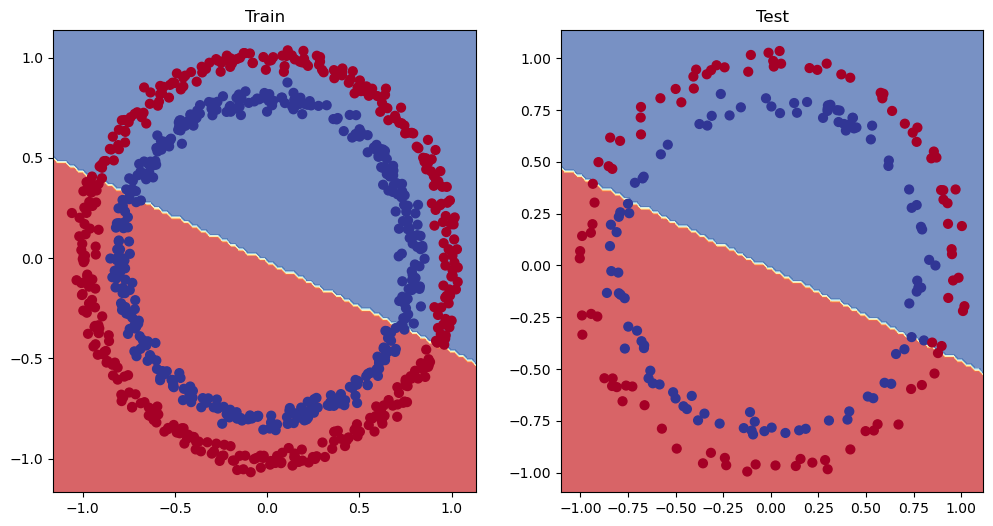

In [30]:
# Plot decision boundary of the model

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
helper_functions.plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
helper_functions.plot_decision_boundary(model_0, X_test, y_test)

### Improving model

* Add more layers
* Add more hidden unit

In [31]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.4469, -0.3959],
                      [ 0.6134, -0.1396],
                      [-0.1118, -0.2707],
                      [ 0.5277, -0.0432],
                      [-0.1602, -0.5098]])),
             ('layer_1.bias',
              tensor([ 0.4486, -0.2676, -0.3400, -0.5075,  0.5704])),
             ('layer_2.weight',
              tensor([[-0.3300,  0.0975,  0.3547, -0.2846, -0.0377]])),
             ('layer_2.bias', tensor([0.1727]))])

In [32]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [33]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.122

In [34]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [35]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_1 = CircleModelV1().to(device)

epoch = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_1.train()
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. perform backpropagation
    loss.backward()

    # 5. perform gradient descent
    optimizer.step()

    # Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate test loss/acc
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        
    if epoch % 10 == 0:
        print(f"Epoch : {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss : {test_loss:.5f}, Test acc : {test_acc:.2f}%")


Epoch : 0 | Loss: 0.69396, Acc: 50.88% | Test loss : 0.69261, Test acc : 51.00%
Epoch : 10 | Loss: 0.69396, Acc: 50.88% | Test loss : 0.69261, Test acc : 51.00%
Epoch : 20 | Loss: 0.69396, Acc: 50.88% | Test loss : 0.69261, Test acc : 51.00%
Epoch : 30 | Loss: 0.69396, Acc: 50.88% | Test loss : 0.69261, Test acc : 51.00%
Epoch : 40 | Loss: 0.69396, Acc: 50.88% | Test loss : 0.69261, Test acc : 51.00%
Epoch : 50 | Loss: 0.69396, Acc: 50.88% | Test loss : 0.69261, Test acc : 51.00%
Epoch : 60 | Loss: 0.69396, Acc: 50.88% | Test loss : 0.69261, Test acc : 51.00%
Epoch : 70 | Loss: 0.69396, Acc: 50.88% | Test loss : 0.69261, Test acc : 51.00%
Epoch : 80 | Loss: 0.69396, Acc: 50.88% | Test loss : 0.69261, Test acc : 51.00%
Epoch : 90 | Loss: 0.69396, Acc: 50.88% | Test loss : 0.69261, Test acc : 51.00%
Epoch : 100 | Loss: 0.69396, Acc: 50.88% | Test loss : 0.69261, Test acc : 51.00%
Epoch : 110 | Loss: 0.69396, Acc: 50.88% | Test loss : 0.69261, Test acc : 51.00%
Epoch : 120 | Loss: 0.69396

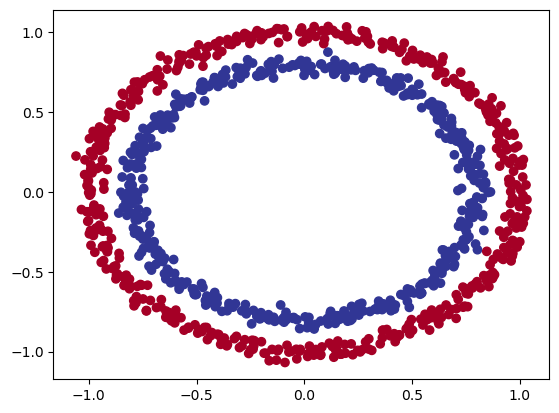

In [36]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)

In [37]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[:5], y_train[:5] 


(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [38]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


In [39]:
device

'cuda'

In [40]:
model_2 = CircleModelV2().to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 5000

for epoch in range(epochs):
    model_2.train()

    y_logits = model_2(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)

    # set zero gradient
    optimizer.zero_grad()

    # perform backpropagation
    loss.backward()

    # perform gradient descent
    optimizer.step()

    model_2.eval()
    with torch.inference_mode():
        test_logits = model_2(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc_loss = accuracy_fn(y_test, test_pred)

    if epoch % 100 == 0:
        print(f"Epoch : {epoch} | Loss : {loss:.2f}, Acc : {acc:.2f}% | Test Loss: {test_loss:.2f} | Test acc: {test_acc_loss}")

Epoch : 0 | Loss : 0.69, Acc : 50.00% | Test Loss: 0.69 | Test acc: 50.0
Epoch : 100 | Loss : 0.69, Acc : 55.12% | Test Loss: 0.69 | Test acc: 52.5
Epoch : 200 | Loss : 0.69, Acc : 50.88% | Test Loss: 0.69 | Test acc: 54.0
Epoch : 300 | Loss : 0.69, Acc : 51.38% | Test Loss: 0.69 | Test acc: 56.00000000000001
Epoch : 400 | Loss : 0.69, Acc : 51.38% | Test Loss: 0.69 | Test acc: 56.00000000000001
Epoch : 500 | Loss : 0.69, Acc : 52.00% | Test Loss: 0.68 | Test acc: 56.00000000000001
Epoch : 600 | Loss : 0.69, Acc : 54.75% | Test Loss: 0.68 | Test acc: 57.49999999999999
Epoch : 700 | Loss : 0.68, Acc : 59.75% | Test Loss: 0.68 | Test acc: 62.0
Epoch : 800 | Loss : 0.68, Acc : 56.75% | Test Loss: 0.68 | Test acc: 57.99999999999999
Epoch : 900 | Loss : 0.68, Acc : 58.63% | Test Loss: 0.67 | Test acc: 60.0
Epoch : 1000 | Loss : 0.67, Acc : 59.62% | Test Loss: 0.67 | Test acc: 59.5
Epoch : 1100 | Loss : 0.67, Acc : 61.12% | Test Loss: 0.67 | Test acc: 62.0
Epoch : 1200 | Loss : 0.66, Acc : 6

#### Evaluating Our Model

In [41]:
model_2.eval()
 
with torch.inference_mode():
    y_logits = model_2(X_test).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))
print(type(y_preds))
y_preds[:10], y_test[:10]

<class 'torch.Tensor'>


(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

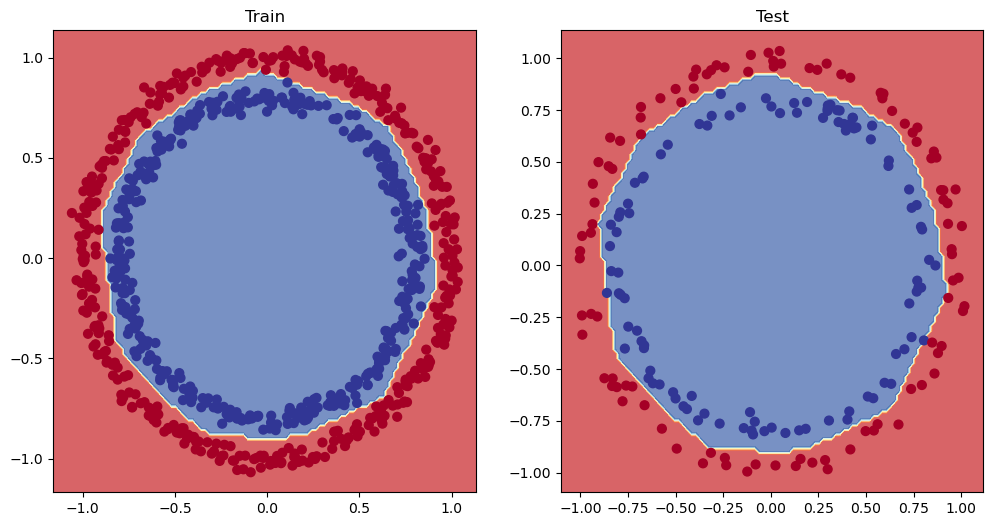

In [42]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
helper_functions.plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
helper_functions.plot_decision_boundary(model_2, X_test, y_test)

#### Multiclass classification

In [43]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

num_classes = 4
num_features = 2
random_seed = 42

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=num_features,
                            centers=num_classes,
                            cluster_std=1.5,
                            random_state=random_seed)

In [44]:
# Convert numpy into torch tensor
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

In [45]:
# Split dataset
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        random_state=42,
                                                                        test_size=0.2)

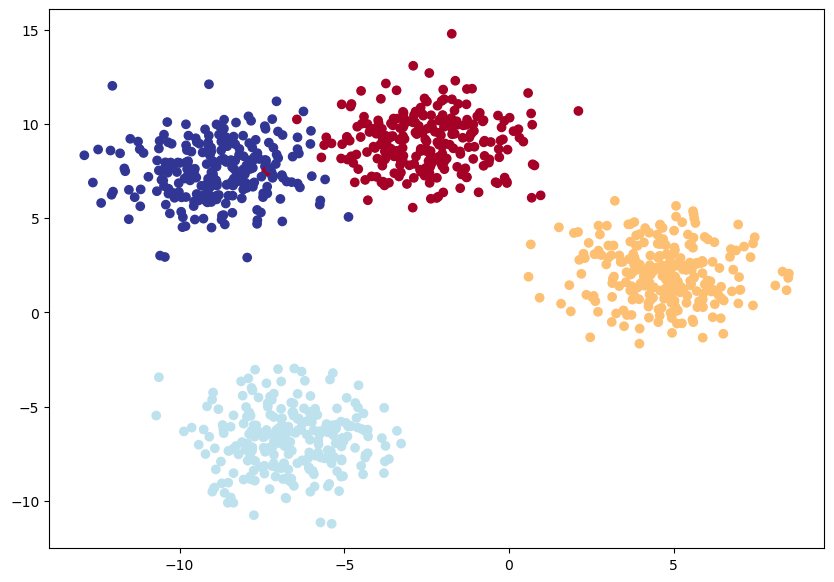

In [46]:
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

In [47]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"


In [74]:
class BlobModel(nn.Module):
    def __init__(self, input_features, out_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=out_features),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=2, out_features=4).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

#### Create a loss function and an optimizer

In [75]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_4.parameters(),
                           lr=0.1)

In [76]:
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device),
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device),

In [77]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test).squeeze()
    y_pred_probs = torch.softmax(y_logits, dim=1)

print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')


In [78]:
y_preds = torch.argmax(y_pred_probs, dim=1) # we set the dimension args cause torch.argmax returns a 0 dimension tensor or just a single scalar tensor
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')

In [79]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='cuda:0')

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

for epoch in range(epochs):
    model_4.train()
    # 1. Forward pass
    y_logits = model_4(X_blob_train).squeeze()
    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1) # <-- get and set the highest index probabilities from the softmax by using argmax

    # calculate the loss and acc
    train_loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_blob_train, y_preds)

    # optinmzer zero grad
    optimizer.zero_grad()

    # backprop
    train_loss.backward()

    # gradient descent
    optimizer.step()

    # testing
    model_4.eval()
    with torch.inference_mode(): # <-- turns off gradient tracking
        y_test_logits = model_4(X_blob_test).squeeze() # <-- removes all ones in the tensor dimension
        y_pred_test = torch.softmax(y_test_logits, dim=1).argmax(dim=1) # <-- multiclass activation functions

        test_loss = loss_fn(y_test_logits, y_blob_test)
        test_acc = accuracy_fn(y_blob_test, y_pred_test)

    if epoch % 100 == 0:
        print(f"Epoch : {epoch} | Loss : {train_loss:.2f}, Acc : {acc:.2f}% | Test Loss: {test_loss:.2f} | Test acc: {test_acc}")

Epoch : 0 | Loss : 1.16, Acc : 40.38% | Test Loss: 1.08 | Test acc: 48.0
Epoch : 100 | Loss : 0.03, Acc : 99.25% | Test Loss: 0.02 | Test acc: 99.5
Epoch : 200 | Loss : 0.03, Acc : 99.25% | Test Loss: 0.02 | Test acc: 99.5
Epoch : 300 | Loss : 0.03, Acc : 99.25% | Test Loss: 0.01 | Test acc: 99.5
Epoch : 400 | Loss : 0.02, Acc : 99.25% | Test Loss: 0.01 | Test acc: 99.5
Epoch : 500 | Loss : 0.02, Acc : 99.25% | Test Loss: 0.01 | Test acc: 99.5
Epoch : 600 | Loss : 0.02, Acc : 99.25% | Test Loss: 0.01 | Test acc: 99.5
Epoch : 700 | Loss : 0.02, Acc : 99.25% | Test Loss: 0.01 | Test acc: 99.5
Epoch : 800 | Loss : 0.02, Acc : 99.25% | Test Loss: 0.01 | Test acc: 99.5
Epoch : 900 | Loss : 0.02, Acc : 99.25% | Test Loss: 0.01 | Test acc: 99.5


### Making a predictions

In [81]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

y_logits[:10]

tensor([[ -2.3751,  10.9387, -10.2038, -11.3271],
        [ -2.1934,  -9.4839,  -6.3062,   5.2288],
        [ -4.9855,  -5.3790,   5.3840,  -4.3115],
        [ -3.0428,   8.1532,  -5.4971,  -6.6867],
        [  6.4903,  -2.8976, -12.3324,  -8.4675],
        [ -2.7724, -11.1928,  -7.4741,   6.3900],
        [ -4.3608,  -4.5814,   4.6890,  -3.5910],
        [  5.8017,  -6.8308,  -9.7351,  -4.1265],
        [ -6.3789,  -6.9228,   6.6638,  -5.5251],
        [  6.2822,  -5.5357, -10.3558,  -5.4748]], device='cuda:0')

In [82]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10] 

tensor([[1.6516e-06, 1.0000e+00, 6.5756e-10, 2.1385e-10],
        [5.9743e-04, 4.0743e-07, 9.7751e-06, 9.9939e-01],
        [3.1372e-05, 2.1166e-05, 9.9989e-01, 6.1553e-05],
        [1.3729e-05, 9.9998e-01, 1.1797e-06, 3.5901e-07],
        [9.9992e-01, 8.3727e-05, 6.6890e-09, 3.1907e-07],
        [1.0490e-04, 2.3113e-08, 9.5250e-07, 9.9989e-01],
        [1.1735e-04, 9.4122e-05, 9.9954e-01, 2.5340e-04],
        [9.9995e-01, 3.2640e-06, 1.7882e-07, 4.8778e-05],
        [2.1657e-06, 1.2571e-06, 9.9999e-01, 5.0865e-06],
        [9.9998e-01, 7.3711e-06, 5.9456e-08, 7.8340e-06]], device='cuda:0')

In [83]:
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 0, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='cuda:0')

In [84]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1], device='cuda:0')

### Visualize

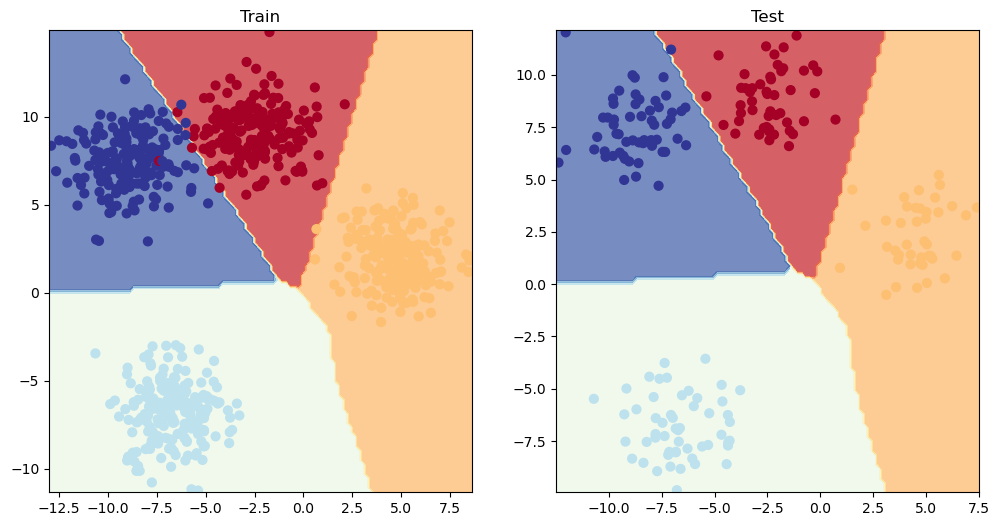

In [85]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
helper_functions.plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
helper_functions.plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [ ]:
from torchmetrics.classification import MulticlassAccuracy

torchmetric_accuracy = MulticlassAccuracy(num_classes=4).to(device)
torchmetric_accuracy(y_preds, y_blob_test)

tensor(0.9956, device='cuda:0')